In [1]:

from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import matplotlib.pyplot as plt
model_path = "/aifs4su/yaodong/changye/model/llava-hf/llava-v1.6-mistral-7b-hf"  # 替换成你的 llava-next 路径
processor = LlavaNextProcessor.from_pretrained(model_path)

model = LlavaNextForConditionalGeneration.from_pretrained(model_path, torch_dtype=torch.float32, low_cpu_mem_usage=True) 
model.to("cuda:0")
# 模型路径（改成你本地或HF路径）
# print(model)

/aifs4su/yaodong/miniconda3/envs/lcy_interp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]


LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn

后 25% patch 的数量: 144


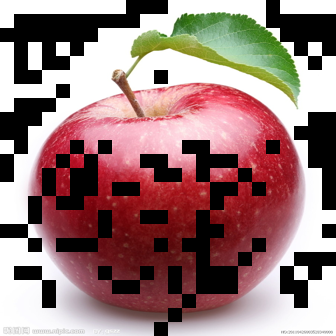

已生成 masked.jpg


In [4]:

import numpy as np
# ========== 2. 准备输入对话 & 图像 ==========
image_path = "/aifs4su/yaodong/changye/TransformerLens-V/Apple.jpg"  # 替换为你的图像路径
image = Image.open(image_path).convert("RGB")

conversation = [
    {
      "role": "user",
      "content": [
          {"type": "text", "text": "What is shown in this image?"},
          {"type": "image"},
      ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(
    images=image,
    text=prompt,
    return_tensors="pt"
).to("cuda")

# ========== 3. 第一次前向传播 -> 获取注意力，定位后25% patch ==========
with torch.no_grad():
    outputs = model.vision_tower(
        pixel_values=inputs["pixel_values"][:, 0, :, :, :],
        output_attentions=True
    )

# outputs.attentions 是一个列表（每层的注意力），
# 形状: (batch_size=1, num_heads, seq_len, seq_len)
hook_layer_idx = -2  # 倒数第二层
attn = outputs.attentions[hook_layer_idx]  # -> [1, heads, seq_len, seq_len]

# 对多头做平均，取 batch=0
attn_avg = attn.mean(dim=1)[0]  # -> (seq_len, seq_len)

# CLS token = 0；其余 patch token = [1..seq_len-1]
# 我们关心 CLS -> 各 patch 的注意力
cls_attn = attn_avg[0, 1:].cpu().numpy()  # (576,) 假设 336×336 /14x14 => 24×24=576

# 找到注意力的 25% 分位数
threshold = np.percentile(cls_attn, 25)
low_attn_indices = np.where(cls_attn <= threshold)[0]
print(f"后 25% patch 的数量: {len(low_attn_indices)}")  # 一般约 144 (576*25%)

# ========== 4. 函数：将指定的 patch 直接涂黑 ==========

def mask_image_patches(
    img: Image.Image,
    patch_indices: np.ndarray,
    patch_size: int = 14,  # 这里为 14x14
    grid_size: int = 24    # 这里 336/14=24
) -> Image.Image:
    """
    将 img (已是 336×336) 拆分为 24×24=576 个14×14大小的 patch，
    对于 patch_indices 中的 patch，直接在图像中置黑色。
    """
    # 转为 numpy array (H, W, C)
    img_np = np.array(img, dtype=np.uint8)
    H, W, C = img_np.shape

    # 检查图像大小是否匹配
    assert H == 336 and W == 336, f"图像尺寸为({H},{W}), 需与(336,336)匹配"
    # 按默认 14×14 和 24×24 网格做简单检查
    assert H == patch_size * grid_size, "patch_size * grid_size不匹配图像大小"

    # 遍历需要 mask 的 patch 索引
    for patch_idx in patch_indices:
        # patch_idx = row * grid_size + col
        row = patch_idx // grid_size
        col = patch_idx % grid_size

        # 计算在图像中的起始坐标
        r_start = row * patch_size
        c_start = col * patch_size

        # 将这个 patch 区域(14×14)设置为黑色
        img_np[r_start:r_start+patch_size, c_start:c_start+patch_size, :] = 0

    # 转回 PIL.Image
    masked_img = Image.fromarray(img_np)
    return masked_img

# ========== 5. 生成并展示被mask后的图片 ==========
# 确保输入图像在推理阶段就是 336x336，如果不是，可以手动 resize 成 336x336 再做可视化
img_resized = image.resize((336, 336))  # 与模型推理时一致

masked_img = mask_image_patches(
    img_resized,
    low_attn_indices,
    patch_size=14,
    grid_size=24
)

# 显示或保存被mask后的图
display(masked_img )          
masked_img.save("masked.jpg")  # 保存到本地
print("已生成 masked.jpg")
